In [295]:
# importing the packages
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date
import sklearn.exceptions
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)



## 1. Loading the data

### Acknowledgements
Link to the data set is the kaggle link as follows:

https://www.kaggle.com/kartik2112/fraud-detection

In [256]:
# loading data
data_train = pd.read_csv("fraudTrain.csv")
data_test = pd.read_csv("fraudTest.csv")

## 2. Exploratory Data Analysis

#### 2.1 Data information

In [284]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129668 entries, 94102 to 1171139
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129668 non-null  int64  
 1   trans_date_trans_time  129668 non-null  object 
 2   cc_num                 129668 non-null  int64  
 3   merchant               129668 non-null  object 
 4   category               129668 non-null  object 
 5   amt                    129668 non-null  float64
 6   first                  129668 non-null  object 
 7   last                   129668 non-null  object 
 8   gender                 129668 non-null  object 
 9   street                 129668 non-null  object 
 10  city                   129668 non-null  object 
 11  state                  129668 non-null  object 
 12  zip                    129668 non-null  int64  
 13  lat                    129668 non-null  float64
 14  long                   129668 n

We see that there are 22 features    
"is_fraud" is the dependent variable 

#### 2.1 Shape of Data


In [257]:
print(df_train.shape,df_test.shape)

(129668, 23) (27786, 23)


#### 2.2 Taking a fraction to run the model faster


In [258]:
# taking smaller sample to run the model faster

df_train= data_train.sample(frac = 0.1,random_state=1)
df_test= data_test.sample(frac = 0.05,random_state=1)
print(df_train.shape,df_test.shape)

(129668, 23) (27786, 23)


In [259]:
df_train.head(3)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
94102,94102,2019-02-25 08:24:40,374497717543058,fraud_Funk Group,grocery_net,20.00,Linda,Hurst,F,31701 Tucker Square Suite 893,...,47.1709,-100.7944,1190,"Designer, ceramics/pottery",1948-06-30,1595dec12f6f19ceaae9b7df0f8af5c0,1330158280,46.398331,-99.813959,0
198791,198791,2019-04-12 19:50:15,4428154703770710,"fraud_Prosacco, Kreiger and Kovacek",home,284.88,Brittany,Guerra,F,79209 Gary Dale,...,46.5901,-117.1692,761,Chief Marketing Officer,1943-06-30,0ed26b649ed0fce94d8e632b7208dea0,1334260215,45.687331,-117.488135,0
1238587,1238587,2020-05-31 21:50:53,213148039875802,"fraud_Langworth, Boehm and Gulgowski",shopping_net,5.07,Jill,Jacobs,F,034 Kimberly Mountains,...,27.9551,-82.2966,79613,Environmental consultant,1978-11-30,7096316ec1a4b261e8613013827abae7,1370037053,27.254081,-81.974799,0


#### 2.3 Checking the null values


In [263]:
df_train.isnull().sum()


Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [264]:
df_test.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

We see that no null values are present.

#### 2.4 Correlation Matrix


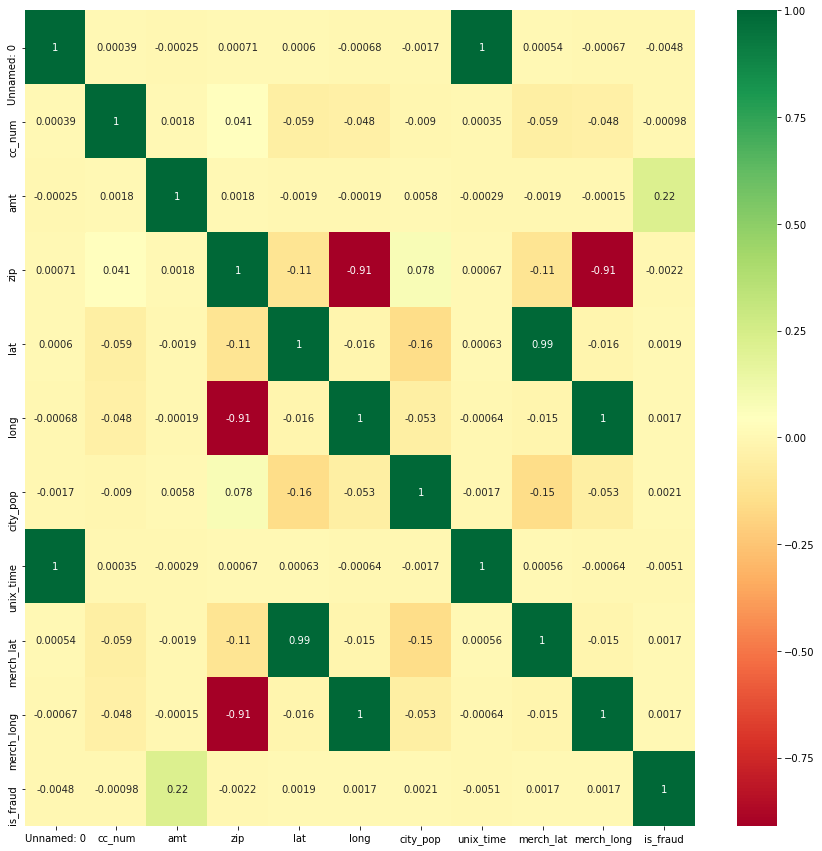

In [246]:
#get correlations of each features in dataset
corrmat = df_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(15,15))

#plot heat map
g=sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

#### 2.5 Histograms

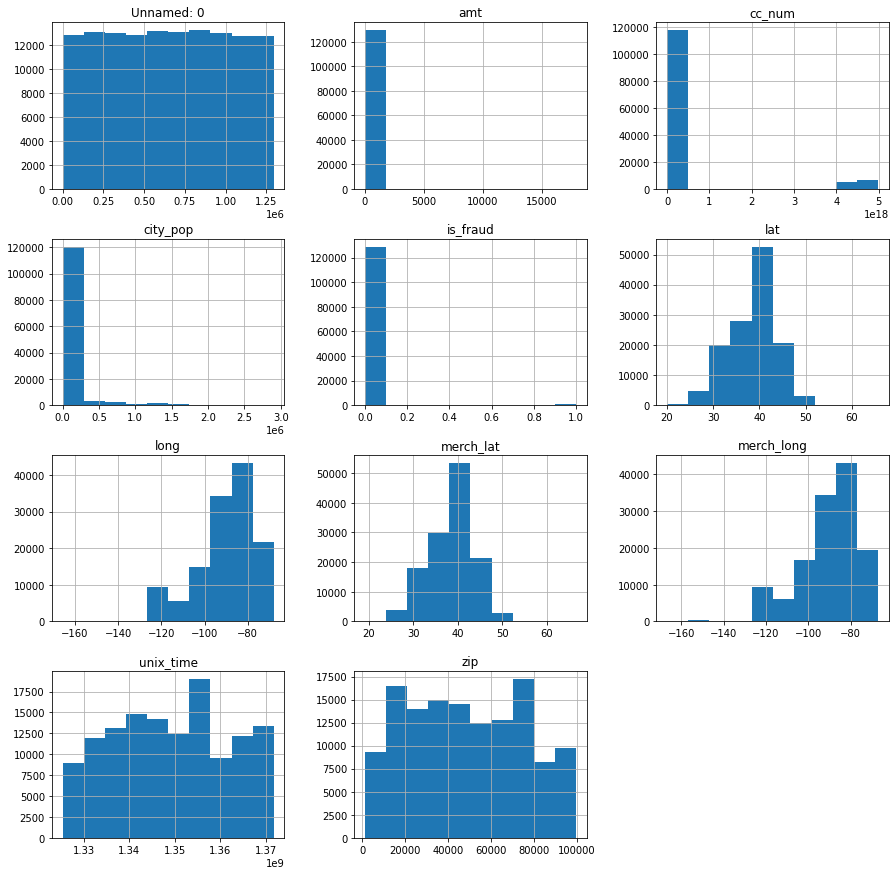

In [260]:
#visual representation of the data using histograms 
df_train.hist(figsize = (15, 15))
plt.show()

#### 2.6 Plotting the classes 

Text(0, 0.5, 'Frequency')

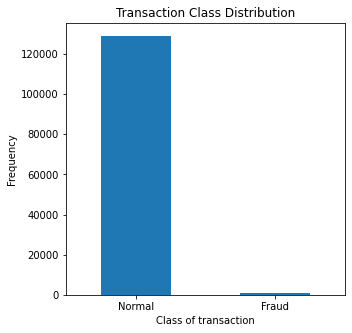

In [271]:
# plotting the classes
plt.figure(figsize=(5,5))
count_classes = pd.value_counts(df_train['is_fraud'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
LABELS = ['Normal','Fraud']
plt.xticks(range(2), LABELS)
plt.xlabel("Class of transaction")
plt.ylabel("Frequency")

We see that data is imbalanced    
#### 2.7  Getting the Fraud and the Normal  transaction numbers for test and train dataset


In [289]:
## Get the Fraud and the normal  transaction numbers for test and train dataset 

fraud_train = df_train[df_train['is_fraud']==1]
normal_train = df_train[df_train['is_fraud']==0]
fraud_test = df_test[df_test['is_fraud']==1]
normal_test = df_test[df_test['is_fraud']==0]

print("Normal cases in train set :",len(df_train)-len(fraud_train),"\nFraud cases in train set :",len(fraud_train))
print("Normal cases in test set :",len(df_test)-len(fraud_test),"\nFraud cases in test set :",len(fraud_test))


Normal cases in train set : 128963 
Fraud cases in train set : 705
Normal cases in test set : 27656 
Fraud cases in test set : 130



## 3. Data transformation and feature engineering


From the exploratory data Analysis we make the following observations:   

1. The first column contains just the indices and is not useful so we will drop it.   
2. The third column with customer card number is also not useful , so we will drop it. 
3. "first name" and "last name" can also be dropped.  
4. Transaction number - is it really needed? can be dropped.
5. Date time column can be used to calculate the age of the customer


#### 3.1 Dropping the columns not needed


In [291]:
# function to drop tbe columns
def dropCol(data):
    col_to_drop = ['trans_date_trans_time','Unnamed: 0','cc_num','first','last','trans_num']
    res = data.drop(col_to_drop,axis = 1)
    return res


In [292]:
# dropping the columns
# dropping the columns ['trans_date_trans_time','Unnamed: 0','cc_num','first','last','trans_num']
# train data set
df_train = dropCol(df_train)
# test data set
df_test = dropCol(df_test)

print ( df_train.shape, df_test.shape)

(129668, 17) (27786, 17)


#### 3.2 Dropping the columns not needed


In [294]:
#Create independent and Dependent Features
columns = df_train.columns.tolist()

# removing the dependent feature is_fraud
columns = [c for c in columns if c not in ["is_fraud"]]

X_train = df_train[columns]
Y_train = df_train['is_fraud']
X_test = df_test[columns]
Y_test = df_test['is_fraud']
print ( X_train.shape, Y_train.shape,X_test.shape, Y_test.shape)

(129668, 16) (129668,) (27786, 16) (27786,)


In [187]:

#rcParams['figure.figsize'] = 14, 8
#RANDOM_SEED = 42
#LABELS = ["Normal", "Fraud"]

#### 3.3 Converting dob to age


In [296]:
# function to convert dob to years
def age_years(born):
    return 2019 - int(born[0:4])

# replacing the dob column with age column in our data set for test and train
X_train['age'] = X_train['dob'].apply(lambda x: age_years(x))
X_train = X_train.drop(['dob'],axis =1)

X_test['age'] = X_test['dob'].apply(lambda x: age_years(x))
X_test = X_test.drop(['dob'],axis =1)
print(X_train.shape,X_test.shape)


(129668, 16) (27786, 16)


#### 3.4 Converting the categorical features to numerical by one- hot - encoding



In [303]:
# concanating the test and train data so that number of columns remain the same in both the data sets
final_df = pd.concat([X_train,X_test],axis=0)
final_df.shape


(157454, 16)

In [190]:
# creating the list of categorical variables
categorical_features =[feature for feature in X_train.columns if final_df[feature].dtypes == 'O']
categorical_features

['merchant', 'category', 'gender', 'street', 'city', 'state', 'job']

In [191]:
#observing the unique values in each feature
for feature in categorical_features:
    print("Distinct categories for {}  are {}".format(feature,len(final_df[feature].unique())))

Distinct categories for merchant  are 693
Distinct categories for category  are 14
Distinct categories for gender  are 2
Distinct categories for street  are 960
Distinct categories for city  are 872
Distinct categories for state  are 51
Distinct categories for job  are 487


In [301]:
# function to convert categorical variables to one hot encoding
def category_onehot_multcols(data,multcolumns):
    df_final = data
    i=0
    for fields in multcolumns:
        print(fields)
        df1=pd.get_dummies(final_df[fields],drop_first=True)
        final_df.drop([fields],axis=1,inplace=True)
        if i==0:
            df_final=df1.copy()
        else:           
            df_final=pd.concat([df_final,df1],axis=1)
        i=i+1             
    df_final=pd.concat([final_df,df_final],axis=1)
    return df_final

In [304]:
# applying the one hot encoding
final_df = category_onehot_multcols(final_df, categorical_features)


merchant
category
gender
street
city
state
job


In [305]:
# removing duplicated columns
final_df =final_df.loc[:,~final_df.columns.duplicated()]
final_df.shape

(157454, 3077)

In [308]:
# separating the test and training data
df_Train=final_df.iloc[:129668,:]
df_Test=final_df.iloc[129668:,:]
print(df_Train.shape,df_Test.shape)

(129668, 3077) (27786, 3077)


In [312]:
print(Y_train.value_counts(),"\n",Y_test.value_counts())

0    128963
1       705
Name: is_fraud, dtype: int64 
 0    27656
1      130
Name: is_fraud, dtype: int64


In [315]:
# files ready for testing on models
print(df_Train.shape, df_Test.shape, Y_train.shape, Y_test.shape)


(129668, 3077) (27786, 3077) (129668,) (27786,)


In [327]:
705/128963

0.005466684242767306

As we see that the data is skewed, i.e the number of samples for class 1 is less tha 0.5% of the samples of class 0.
In this case the the machine learning algorithms with not predict the Fraud cases correctly.
To predict the Fraud correctly we have two approaches:   
1. Handle the imbalance in Data and apply various Machine Learning algorithms    
2. Predict Fraud as outlier/Anomaly  

We proceed for the first method first.


## 4. Handling the Imbalance in data 

There can be two approaches to predict the the fraud cases:   
4.1. Handle the Imbalance in data by one of the following methods:   
> 4.1.1 Under Sampling   
       4.1.2 Over Sampling   
       4.1.3 SMOTE (Synthetic Minority over sampling technique)   
       4.1.4 Near Miss algorighm ( under sampling )   
       4.1.5 Ensemble method 
   




First we apply the model without handling the imbalance. We will use Logistic Regression and Decision Tree classifier for our exploration of the method to apply to handle imbalance in data. 

In [316]:
# Logistic Regression
model_LR = LogisticRegression()
model_LR.fit(df_Train,Y_train)
y_pred = model_LR.predict(df_Test)

LogisticRegression()

In [321]:
#Let's evaluate our model 
def print_eval(y_pred,model):
    print("Training Accuracy: ",model.score(df_Train, Y_train))
    print("Testing Accuracy: ", model.score(df_Test, Y_test))
    cm = confusion_matrix(Y_test, y_pred)
    print(cm)
    print(classification_report(Y_test,y_pred))


In [322]:
print_eval(y_pred,model_LR)

Training Accuracy:  0.9945630379122066
Testing Accuracy:  0.9953213848700785
[[27656     0]
 [  130     0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27656
           1       0.00      0.00      0.00       130

    accuracy                           1.00     27786
   macro avg       0.50      0.50      0.50     27786
weighted avg       0.99      1.00      0.99     27786



In [323]:
# decision tree
decision_tree_model = DecisionTreeClassifier(random_state=137)
decision_tree_model.fit(df_Train,Y_train)
y_pred = decision_tree_model.predict(df_Test)
print_eval(y_pred,decision_tree_model)

Training Accuracy:  1.0
Testing Accuracy:  0.9866839415533002
[[27333   323]
 [   47    83]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     27656
           1       0.20      0.64      0.31       130

    accuracy                           0.99     27786
   macro avg       0.60      0.81      0.65     27786
weighted avg       0.99      0.99      0.99     27786



#### Metric Analysis

1. **True  Positives** : Correctly classified as Safe Transaction     = 27333 (.99)   
2. **False Negitives** : Mis-classified Safe Transaction              = 323 (Harmless)   
3. **False Positives** : Mis-classified as Fraud Transactions         = 47 (Dangerous )   
4. **True Negatives**  : Correctly classified as Fraud Transactions   = 83 (out of 130 -> .64)   
5. **Accuracy**        : .99   

Here the accuracy is not taken into account as it is misleading.   
We want to get maximum True Negatives i.e we want to predict the Fraud tranactions with maximum accuracy. This can be done by monitoring the Recall.

So when the data is imbalanced the Recall is    
class 0 (Safe) : 0.99   
class 1 (Fraud): 0.64   

**We want the recall of class 1 to be close to 1.00**    
**We can also use f1-score as a metric to observe**




### 4.1.1 Implementing Undersampling


In [328]:
# adding the dependent feature in the train data set
print(Y_train.shape,df_Train.shape)
df_train = pd.concat([df_Train,Y_train],axis = 1)
df_train.shape


(129668,) (129668, 3077)


(129668, 3078)

In [329]:
# Class count
count_class_0, count_class_1 = df_train.is_fraud.value_counts()
print(count_class_0, count_class_1)
# Divide by class
df_class_0 = df_train[df_train['is_fraud'] == 0]
df_class_1 = df_train[df_train['is_fraud'] == 1]
print(df_class_0.shape,df_class_1.shape)

128963 705
(128963, 3078) (705, 3078)


In [330]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(count_class_1)
df_train_under_sample = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_train_under_sample.is_fraud.value_counts())


Random under-sampling:
1    705
0    705
Name: is_fraud, dtype: int64


In [334]:
# training and predictions : Logistic Regression
X = df_train_under_sample.drop('is_fraud',axis='columns')
y = df_train_under_sample['is_fraud']
model_LR_under_sample = LogisticRegression()
model_LR_under_sample.fit(X,y)
y_pred = model_LR.predict(df_Test)
print_eval(y_pred,model_LR_under_sample)

Training Accuracy:  0.8673921090785699
Testing Accuracy:  0.8688548189735839
[[27656     0]
 [  130     0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27656
           1       0.00      0.00      0.00       130

    accuracy                           1.00     27786
   macro avg       0.50      0.50      0.50     27786
weighted avg       0.99      1.00      0.99     27786



In [338]:
# training and predictions : decision tree
decision_tree_model_undersample = DecisionTreeClassifier(random_state=137)
decision_tree_model_undersample.fit(X,y)
y_pred = decision_tree_model_undersample.predict(df_Test)
print_eval(y_pred,decision_tree_model_undersample)

Training Accuracy:  0.939399080729247
Testing Accuracy:  0.9397898222126251
[[25990  1666]
 [    7   123]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     27656
           1       0.07      0.95      0.13       130

    accuracy                           0.94     27786
   macro avg       0.53      0.94      0.55     27786
weighted avg       1.00      0.94      0.96     27786



### Comparision of results and Observations :

|                                       | Class-0 Recall| Class-1 Recall|Class-0 f1-score| Class-1 f1-score|
|---------------------------------------|---------------|---------------|----------------|-----------------|
|Logistic Regression                    |     1.00      |     0.00      |     1.00       |      0.00       |
|Decision Tree Classifier               |     0.99      |     0.64      |     0.99       |      0.31       |
|Logistic Regression Under Sampling     |     1.00      |     0.00      |     1.00       |      0.50       |
|Decision Tree Classifier Under Sampling|     0.94      |     0.95      |     0.97       |      0.13       |


### 4.1.2 Implementing Oversampling

In [339]:
# Class count
count_class_0, count_class_1 = df_train.is_fraud.value_counts()
print(count_class_0, count_class_1)
# Divide by class
df_class_0 = df_train[df_train['is_fraud'] == 0]
df_class_1 = df_train[df_train['is_fraud'] == 1]
print(df_class_0.shape,df_class_1.shape)

128963 705
(128963, 3078) (705, 3078)


In [341]:
# Oversample 1-class and concat the DataFrames of both class
df_class_1_over = df_class_1.sample(count_class_0,replace=True)
df_train_over_sample = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')

print(df_train_over_sample.is_fraud.value_counts())

Random over-sampling:
1    128963
0    128963
Name: is_fraud, dtype: int64


In [342]:
# training and predictions : Logistic Regression
X = df_train_over_sample.drop('is_fraud',axis='columns')
y = df_train_over_sample['is_fraud']
model_LR_over_sample = LogisticRegression()
model_LR_over_sample.fit(X,y)
y_pred = model_LR_over_sample.predict(df_Test)
print_eval(y_pred,model_LR_over_sample)

Training Accuracy:  0.8591479779128235
Testing Accuracy:  0.8621608004030807
[[23944  3712]
 [  118    12]]
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     27656
           1       0.00      0.09      0.01       130

    accuracy                           0.86     27786
   macro avg       0.50      0.48      0.47     27786
weighted avg       0.99      0.86      0.92     27786



In [344]:
# training and predictions : decision tree
decision_tree_model_over_sample = DecisionTreeClassifier(random_state=137)
decision_tree_model_over_sample.fit(X,y)
y_pred = decision_tree_model_over_sample.predict(df_Test)
print_eval(y_pred,decision_tree_model_over_sample)

Training Accuracy:  1.0
Testing Accuracy:  0.9938098322896423
[[27580    76]
 [   96    34]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27656
           1       0.31      0.26      0.28       130

    accuracy                           0.99     27786
   macro avg       0.65      0.63      0.64     27786
weighted avg       0.99      0.99      0.99     27786



### Comparision of results and Observations :

|                                       | Class-0 Recall| Class-1 Recall|Class-0 f1-score| Class-1 f1-score|
|---------------------------------------|---------------|---------------|----------------|-----------------|
|Logistic Regression                    |     1.00      |     0.00      |     1.00       |      0.00       |
|Decision Tree Classifier               |     0.99      |     0.64      |     0.99       |      0.31       |
|Logistic Regression Under Sampling     |     1.00      |     0.00      |     1.00       |      0.50       |
|Decision Tree Classifier Under Sampling|     0.94      |   **0.95**    |     0.97       |      0.13       |
|Logistic Regression Over Sampling      |     0.87      |     0.09      |     0.93       |      0.01       |
|Decision Tree Classifier Over Sampling |     1.00      |     0.26      |     1.00       |      0.28       |

**We see that Under sampling gives better results till now**


### 4.1.3 Implementing SMOTE (Synthetic Minority Over Sampling Technique)

In [345]:
# smote implementation
smote = SMOTE(sampling_strategy = 'minority')
X_sm, y_sm = smote.fit_sample(X, y)
y_sm.value_counts()

1    128963
0    128963
Name: is_fraud, dtype: int64

In [346]:
# training and predictions : Logistic Regression

model_LR_smote = LogisticRegression()
model_LR_smote.fit(X_sm,y_sm)
y_predict = model_LR_smote.predict(df_Test)
print_eval(y_pred,model_LR_smote)

Training Accuracy:  0.8591479779128235
Testing Accuracy:  0.8621608004030807
[[27580    76]
 [   96    34]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27656
           1       0.31      0.26      0.28       130

    accuracy                           0.99     27786
   macro avg       0.65      0.63      0.64     27786
weighted avg       0.99      0.99      0.99     27786



In [347]:
# training and predictions : decision tree
decision_tree_model_smote = DecisionTreeClassifier(random_state=137)
decision_tree_model_smote.fit(X_sm,y_sm)
y_pred = decision_tree_model_smote.predict(df_Test)
print_eval(y_pred,decision_tree_model_smote)

Training Accuracy:  1.0
Testing Accuracy:  0.9938098322896423
[[27580    76]
 [   96    34]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27656
           1       0.31      0.26      0.28       130

    accuracy                           0.99     27786
   macro avg       0.65      0.63      0.64     27786
weighted avg       0.99      0.99      0.99     27786



### Comparision of results and Observations :

|                                       | Class-0 Recall| Class-1 Recall|Class-0 f1-score| Class-1 f1-score|
|---------------------------------------|---------------|---------------|----------------|-----------------|
|Logistic Regression                    |     1.00      |     0.00      |     1.00       |      0.00       |
|Decision Tree Classifier               |     0.99      |     0.64      |     0.99       |      0.31       |
|Logistic Regression Under Sampling     |     1.00      |     0.00      |     1.00       |      0.50       |
|Decision Tree Classifier Under Sampling|     0.94      |   **0.95**    |     0.97       |      0.13       |
|Logistic Regression Over Sampling      |     0.87      |     0.09      |     0.93       |      0.01       |
|Decision Tree Classifier Over Sampling |     1.00      |     0.26      |     1.00       |      0.28       |
|Logistic Regression SMOTE              |     1.00      |     0.26      |     1.00       |      0.28       |
|Decision Tree ClassifierSMOTE          |     1.00      |     0.26      |     1.00       |      0.28       |

**We see that Under sampling gives better results till now**

In [226]:
from imblearn.under_sampling import NearMiss 
nr = NearMiss() 
  
X_train_miss, y_train_miss = nr.fit_sample(X, y) 

In [227]:
y_train_miss.value_counts()

1    128963
0    128963
Name: is_fraud, dtype: int64

In [228]:
# training and predictions : Logistic Regression

model_LR_smote = LogisticRegression()
model_LR_smote.fit(X_train_miss,y_train_miss)
y_predict = model_LR_smote.predict(df_Test)
print(classification_report(Y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93     55332
           1       0.00      0.08      0.01       240

    accuracy                           0.86     55572
   macro avg       0.50      0.47      0.47     55572
weighted avg       0.99      0.86      0.92     55572



In [229]:
# training and predictions : decision tree
decision_tree_model = DecisionTreeClassifier(random_state=137)
decision_tree_model.fit(X_train_miss,y_train_miss)
y_pred = decision_tree_model.predict(df_Test)
print("Classification Report: \n", classification_report(Y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     55332
           1       0.39      0.57      0.46       240

    accuracy                           0.99     55572
   macro avg       0.69      0.78      0.73     55572
weighted avg       1.00      0.99      0.99     55572



If we see the Recall metric for fraud detection, under sampling gave the best results.    

 class 0 0.94     
 
 cladd 1 0.97    

   
4.2. Considering the Fraud cases as anamoly and use anamoly detection methods such as:   
> 4.2.1 Simple Statistical Methods : Metrics such as distribution, including mean, median, mode, and quantiles could be used to identify outliers since the definition of an anomalous data point is one that deviates by a certain standard deviation from the mean. 
       4.2.2 Density-Based Anomaly Detection : These include the k-nearest neighbors algorithm, Relative density of data based method known as local outlier factor (LOF) algorithm    
       4.2.3 Clustering-Based Anomaly Detection : K-means algorithm  
       4.2.4 Support Vector Machine-Based Anomaly Detection      
       4.2.5 Isolation Forest : https://www.youtube.com/watch?v=TP3wdwD8JVY    
       4.2.6 Using Auto Encoders : https://www.youtube.com/watch?v=S31E-ftRfQI
   
